In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [3]:
!pip install kaggle

In [14]:
cd /root/

/root


In [18]:
!mkdir .kaggle

In [19]:
ls -a

./   .bashrc*  .config/  .ipython/  .kaggle/  .local/  .profile
../  .cache/   .gsutil/  .jupyter/  .keras/   .npm/    .tmux.conf*


In [20]:
import json
token = {"username":"rridhijain","key":"12722489288ce3cf875d92e6deff9687"}
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [21]:
!kaggle datasets download -d ashishsaxena2209/animal-image-datasetdog-cat-and-panda

 96% 361M/376M [00:08<00:00, 34.9MB/s]
100% 376M/376M [00:08<00:00, 43.8MB/s]


In [22]:
ls -a

./                                         .cache/    .jupyter/  .npm/
../                                        .config/   .kaggle/   .profile
animal-image-datasetdog-cat-and-panda.zip  .gsutil/   .keras/    .tmux.conf*
.bashrc*                                   .ipython/  .local/


In [23]:
!unzip animal-image-datasetdog-cat-and-panda.zip

Streaming output truncated to the last 5000 lines.
  inflating: animals/animals/dogs/dogs_00007.jpg  
  inflating: animals/animals/dogs/dogs_00008.jpg  
  inflating: animals/animals/dogs/dogs_00009.jpg  
  inflating: animals/animals/dogs/dogs_00010.jpg  
  inflating: animals/animals/dogs/dogs_00011.jpg  
  inflating: animals/animals/dogs/dogs_00012.jpg  
  inflating: animals/animals/dogs/dogs_00013.jpg  
  inflating: animals/animals/dogs/dogs_00014.jpg  
  inflating: animals/animals/dogs/dogs_00015.jpg  
  inflating: animals/animals/dogs/dogs_00016.jpg  
  inflating: animals/animals/dogs/dogs_00017.jpg  
  inflating: animals/animals/dogs/dogs_00018.jpg  
  inflating: animals/animals/dogs/dogs_00019.jpg  
  inflating: animals/animals/dogs/dogs_00020.jpg  
  inflating: animals/animals/dogs/dogs_00021.jpg  
  inflating: animals/animals/dogs/dogs_00022.jpg  
  inflating: animals/animals/dogs/dogs_00023.jpg  
  inflating: animals/animals/dogs/dogs_00024.jpg  
  inflating: animals/animals/do

In [34]:
cd /root/animals/animals

/root/animals/animals


In [35]:
ls -a

./  ../  cats/  dogs/  panda/


In [4]:
import os

num_skipped = 0
for folder_name in ("cats", "dogs", "panda"):
    folder_path = os.path.join("/root/animals/animals/", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


In [5]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/root/animals/animals",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/root/animals/animals",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 3000 files belonging to 3 classes.
Using 2400 files for training.
Found 3000 files belonging to 3 classes.
Using 600 files for validation.


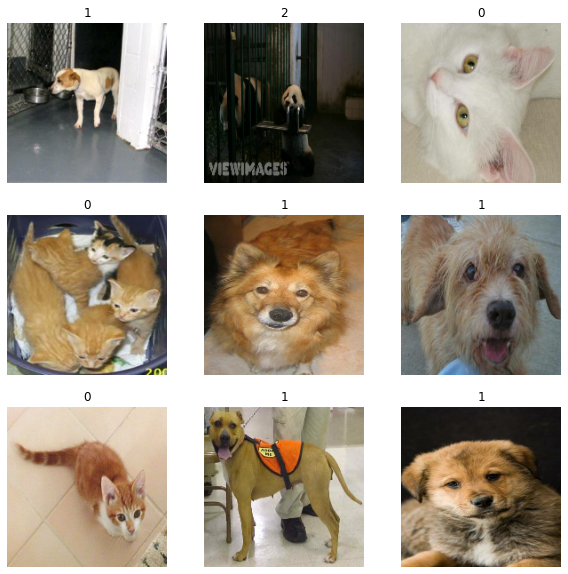

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [7]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

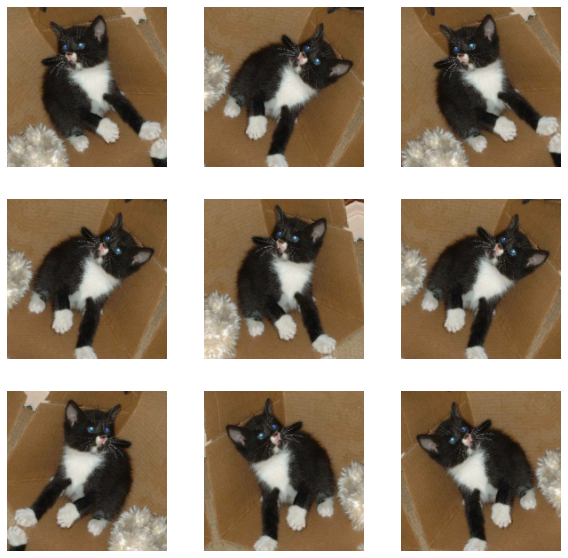

In [8]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

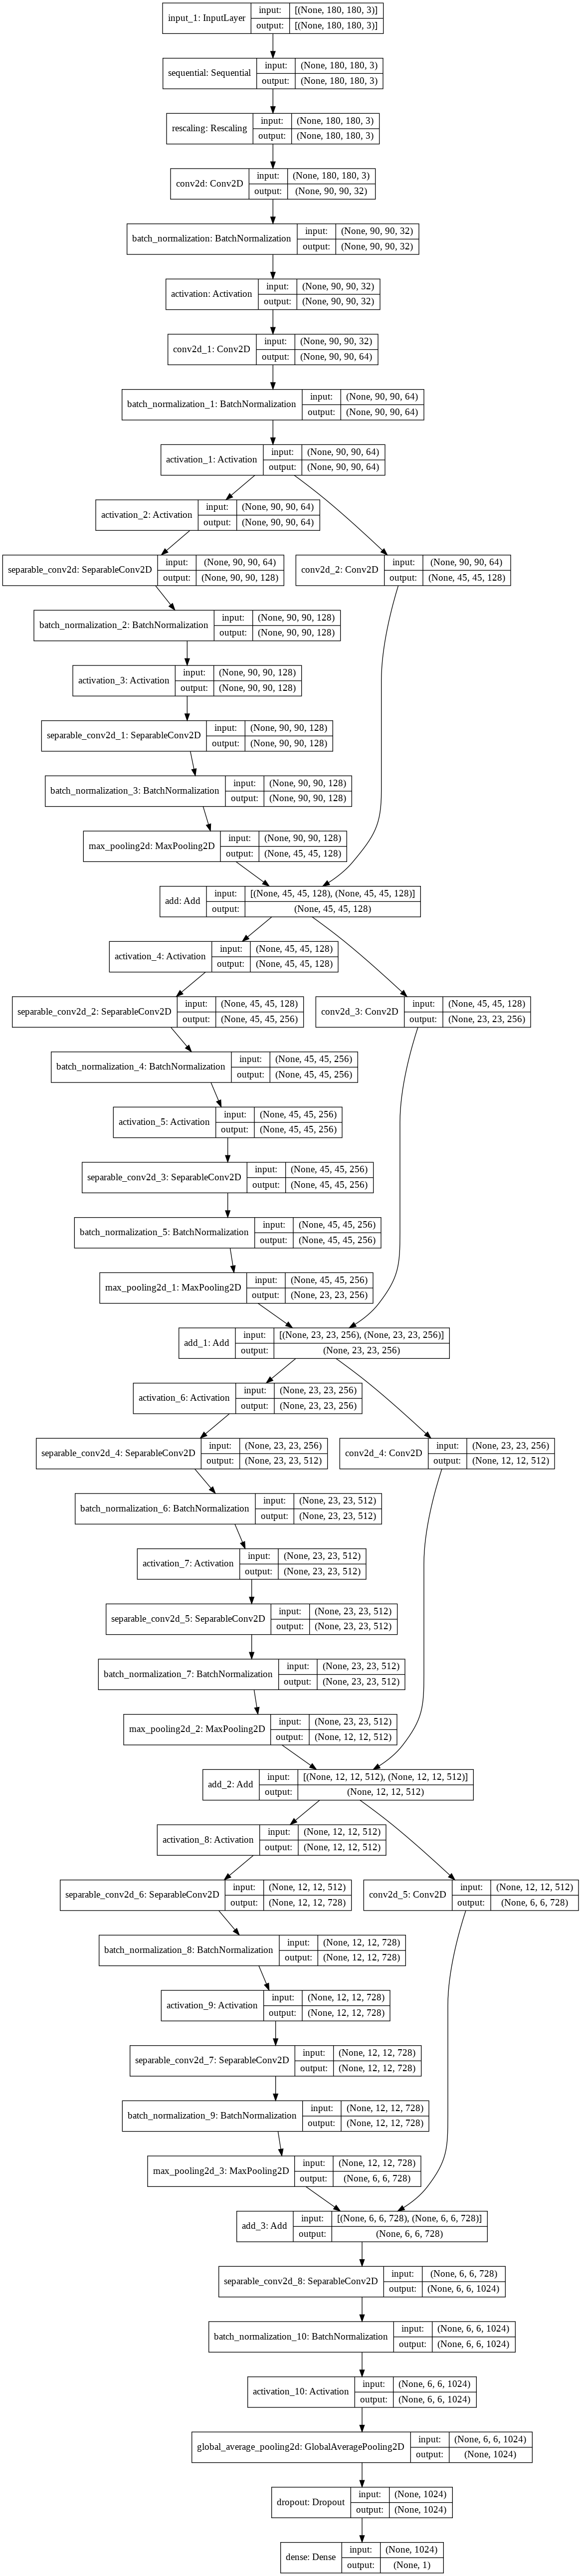

In [9]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 3:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=3)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/10
75/75 [==============================] - 612s 8s/step - loss: -0.9335 - accuracy: 0.3838 - val_loss: 0.7216 - val_accuracy: 0.3133
Epoch 2/10
75/75 [==============================] - 608s 8s/step - loss: -5.1096 - accuracy: 0.3761 - val_loss: 0.6526 - val_accuracy: 0.3517
Epoch 3/10
75/75 [==============================] - 604s 8s/step - loss: -8.3409 - accuracy: 0.3756 - val_loss: 0.6178 - val_accuracy: 0.3517
Epoch 4/10
75/75 [==============================] - 600s 8s/step - loss: -11.3418 - accuracy: 0.3741 - val_loss: 0.5697 - val_accuracy: 0.3517
Epoch 5/10
75/75 [==============================] - 603s 8s/step - loss: -14.3047 - accuracy: 0.3774 - val_loss: 0.5004 - val_accuracy: 0.3517
Epoch 6/10
75/75 [==============================] - 601s 8s/step - loss: -17.0506 - accuracy: 0.4025 - val_loss: 0.4998 - val_accuracy: 0.3517
Epoch 7/10
75/75 [==============================] - 604s 8s/step - loss: -20.2544 - accuracy: 0.3968 - val_loss: 0.5766 - val_accuracy: 0.3700
Ep

In [ ]:
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)